In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import statistics as st
import os
import pickle
import glob
from scipy import stats
%matplotlib inline
import random
import seaborn as sn
from IPython.display import display, HTML
from scipy.stats import norm
from scipy.optimize import curve_fit

display(HTML("<style>.container { width:80% !important; }</style>"))

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
NumofPE=lambda Wb,R,g,e:Wb/(R*g*e)

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def getValuesWithSource(files,weight):
    values={} 

    for i in files:
        count=0
        sources={}
        with open(i) as f:
            next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                if(splitline[0] in values.keys()):
                    if(splitline[1] in values[splitline[0]].keys()):
                        values[splitline[0]][splitline[1]]=np.append(values[splitline[0]][splitline[1]],round(int(splitline[2])/weight))
                    else:
                        sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                        values[splitline[0]][splitline[1]]=sources[splitline[1]]
                else:
                    sources={}
                    sources[splitline[1]]=np.array(round(int(splitline[2])/weight))
                    values[splitline[0]]=sources
        f.close()
        
    return values
### Photons

## point Source
Point_SolidAngle=lambda r,R:(r**2/(4*R**2))

## Disk Source
### Where A is Rs/d ,and B is Rd/d
Disk_SolidAngle=lambda A,B:(B**2/4)*(1-3/4*(A**2+B**2)+15/8*(1/3*(A**4+B**4)+(A*B)**2)-35/16*(1/4*(A**6+B**6)+3/2*(A*B)**2*(A**2+B**2)))

def getAll(Path):
    Files = glob.glob(Path,recursive=True)
    Values=getValuesWithSource(Files,1)
    return Values
    
def SmearIT(mean,percent):
    return np.random.normal(mean,mean*percent)

def CombineIT(data):
    entrie=-1
    for key in data:
        if(len(data[key])>entrie):
            entrie=len(data[key])
    
    valuearr=np.zeros(entrie)
  
    print(f"Number of Values is {entrie}")
    for key in data:
        count=0 
        for val in data[key]:
            valuearr[count]=valuearr[count]+val
            count=count+1
    return valuearr

def ObtainValues(values):
    ### Applying Constants
        
    Results={}
    E1000ms=getAll(values["Path"])
    Alphas=E1000ms['All_e']["Po210"]
    Betas=E1000ms['All_e']["Bi210"]
    ## Solid Angle Calculations
    SolidAngle_AnodeWindowAlphas=Alphas*Point_SolidAngle(values["AnodeWindowRadius"],values["AnodePMTDistance"])*values["ELGain"]*values["AnodeQE"]*values["AnodeScale"]
    SolidAngle_CathodeWindowAlphas=Alphas*Point_SolidAngle(values["CathodeWindowRadius"],values["CathodePMTDistance"])*values["ELGain"]*values["CathodeQE"]*values["CathodeScale"]
    Results["SolidAngle_CathodeWindowBetas"]=Betas*Point_SolidAngle(values["CathodeWindowRadius"],values["CathodePMTDistance"])*values["ELGain"]*values["CathodeQE"]*values["CathodeScale"]
    Results["SolidAngle_AnodeWindowBetas"]=Betas*Point_SolidAngle(values["AnodeWindowRadius"],values["AnodePMTDistance"])*values["ELGain"]*values["AnodeQE"]*values["AnodeScale"]
    #### Adding Smearing 
   
    Results["SolidAngle_CathodeWindowAlphas"]=SmearIT(SolidAngle_CathodeWindowAlphas,values["Smearing"])
    Results["SolidAngle_AnodeWindowAlphas"]=SmearIT(SolidAngle_AnodeWindowAlphas,values["Smearing"])

    
    Cathode_Alphas=E1000ms["Cathode_PHOTOCATHODE"]["Po210"]*values["CathodeQE"]
    Anode_Alphas=E1000ms["Anode_PHOTOCATHODE"]["Po210"]*values["AnodeQE"]
    
    Results["CathodeBetaPEs_G4"]=E1000ms["Cathode_PHOTOCATHODE"]["Bi210"]*values["CathodeQE"]
    Results["AnodeBetaPEs_G4"]=E1000ms["Anode_PHOTOCATHODE"]["Bi210"]*values["AnodeQE"]
    ## G4
    if(not values["Updated"]):
        Cathode_Alphas=Cathode_Alphas*values["CathodeScale"]
        Anode_Alphas=Anode_Alphas*values["AnodeScale"]
        Results["CathodeBetaPEs_G4"]=Results["CathodeBetaPEs_G4"]*values["CathodeScale"]
        Results["AnodeBetaPEs_G4"]=Results["AnodeBetaPEs_G4"]*values["AnodeScale"]
        
            ##### Adding Smearing 
    Results["CathodeAlphaPEs_G4"]=SmearIT(Cathode_Alphas,values["Smearing"])
    Results["AnodeAlphaPEs_G4"]=SmearIT(Anode_Alphas,values["Smearing"])
    return Results
    

def Fit(data,binss,fvalue=0):
    # Define some test data which is close to Gaussian
    data=data[data>fvalue]
    hist, bin_edges,__ = plt.hist(data,bins=binss,density=True)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [np.max(data), np.mean(data), np.std(data)]

    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

    # Get the fitted curve
    hist_fit = gauss(bin_centres, *coeff)

    plt.plot(bin_centres, hist, label='Test data')
    plt.plot(bin_centres, hist_fit, label='Fitted data')

    # Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
    print ('Fitted mean = ', coeff[1])
    print ('Fitted standard deviation = ', coeff[2])

    plt.legend()
    plt.show()
    return coeff


def MultiFileIonizationElectronPosition(files,mother,TargetVolume=b'EL_GAP',TargetParticle=b'opticalphoton',EventLimit=2,FileName="Optical.p"):
    count=0
    values={}
    
    if(EventLimit==-1):
        EventLimit=len(files)
    filecount=0
    for file in files:
        print(f"Analyzing following  file --> {file}\n" )
        data = getvalues(file)
        TotalEvents=int(data['configuration'][2][1])
        FinalPosition={"particle_name":[],"x":[],"y":[],"z":[]}
    
        for EventID in range(0,TotalEvents):
            #Obtain current event id
            EventIDMask=data["particles"]["event_id"]==EventID
            
            #Store particle infor for this event
            ParticlesTable=data["particles"][EventIDMask]
            
            #Create Mother mask for expected mother
            MotherMask=ParticlesTable["particle_name"]==mother
            
            ## Particle Name Mask
            
            #Interested particles
            ParticleNameMask=ParticlesTable["particle_name"]==TargetParticle
            ParticlesInInterest=ParticlesTable[ParticleNameMask]
            if(TargetVolume!=None):
                IonizationElectronsMask=ParticlesInInterest["final_volume"]==TargetVolume
                ParticlesInInterest=ParticlesInInterest[IonizationElectronsMask]
           
            IonizationElectronMotherID=ParticlesInInterest["mother_id"]

            #Expected Mother IDs
            ExpectedMotherID=ParticlesTable["particle_id"][MotherMask]
            
            #Find intersection of the motherIds of ie and Expected Mother
            MotherIDMask=np.isin(IonizationElectronMotherID,ExpectedMotherID)
            FinalPosition["particle_name"]=ParticlesInInterest["particle_name"][MotherIDMask]
            FinalPosition["x"]=ParticlesInInterest["final_x"][MotherIDMask]
            FinalPosition["y"]=ParticlesInInterest["final_y"][MotherIDMask]
            FinalPosition["z"]=ParticlesInInterest["final_z"][MotherIDMask]
            values[count]=FinalPosition
            count=count+1
            
        if(filecount>=EventLimit):
            break
        filecount=filecount+1
    if(FileName==""):
        PickleITDump(values,"Electrons.p")
    else:
        PickleITDump(values,FileName+".p")
    print("Events are saved!")
    return values




In [3]:
S1=getAll("/media/ilker/Ilker/SimResults/Mar12_2023_Recombinations/Updated_S1_NoNeedle/counts/Extra_*")
NoS1=getAll("/media/ilker/Ilker/SimResults/Mar12_2023_Recombinations/Updated_NoS1_NoNeedle/counts/Extra_*")

(array([ 90., 196.,  26., 241., 386.,  31.,  10.,   6.,   3.,   2.,   4.,
          0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   1.]),
 array([0.55920098, 0.56267077, 0.56614056, 0.56961034, 0.57308013,
        0.57654992, 0.58001971, 0.5834895 , 0.58695929, 0.59042908,
        0.59389887, 0.59736865, 0.60083844, 0.60430823, 0.60777802,
        0.61124781, 0.6147176 , 0.61818739, 0.62165718, 0.62512697,
        0.62859675]),
 <BarContainer object of 20 artists>)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


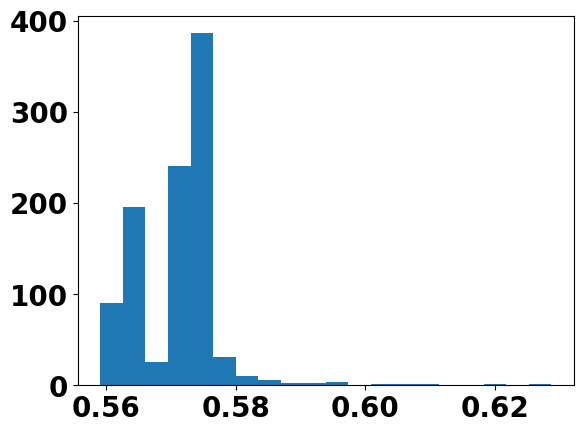

In [4]:
Factor=S1["Total_Produced_Photons"]['None']/S1["Total_Produced_ie"]['None']
plt.hist(Factor,bins=20)

148906.516


(array([ 95., 153., 172., 162., 129., 118.,  85.,  53.,  27.,   6.]),
 array([138226. , 141082.9, 143939.8, 146796.7, 149653.6, 152510.5,
        155367.4, 158224.3, 161081.2, 163938.1, 166795. ]),
 <BarContainer object of 10 artists>)

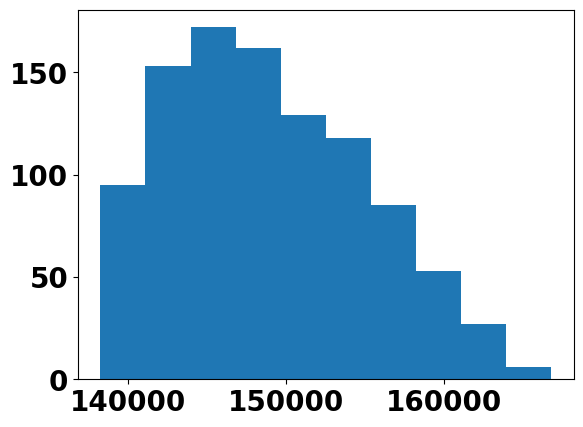

In [9]:
 
#plt.figure(figsize=(3,2),dpi=300)
#plt.hist(S1["Total_Produced_ie"]['None'])
#plt.hist(NoS1["Total_Produced_ie"]['None'])
np.mean((S1["Total_Produced_ie"]['None']-NoS1["Total_Produced_ie"]['None'])/S1["Total_Produced_ie"]['None']*100)

print(np.mean(S1["Total_Produced_Photons"]["None"]))
np.mean(S1["Total_Produced_ie"]['None'])

plt.hist(S1["Total_Produced_Photons"]["None"])

In [ ]:
n